# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

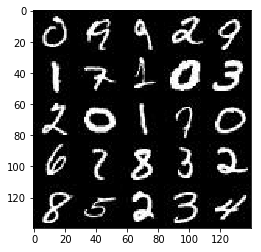

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

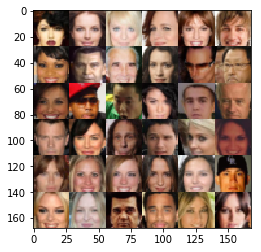

In [3]:
show_n_images = 40

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_images = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_images')
    imput_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return input_images, imput_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False,alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    kinit = tf.random_normal_initializer(mean=0.0, stddev=0.02)
    
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, 
                              strides=2, 
                              kernel_initializer = kinit,
                              padding='same')
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(x1, 128, 5, 
                              strides=2,
                              kernel_initializer = kinit,
                              padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, 
                              strides=2, 
                              kernel_initializer = kinit,
                              padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 =  tf.maximum(alpha * bn3, bn3)
        
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat,1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True,alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    kinit = tf.random_normal_initializer(mean=0.0, stddev=0.02)
    
    with tf.variable_scope('generator',reuse=not is_train):
    
        x1 = tf.layers.dense(z, 7*7*256)
  
        x1 = tf.reshape(x1, (-1,7,7,256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=1,
                                        kernel_initializer = kinit,
                                        padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2,
                                        kernel_initializer = kinit,
                                        padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2,
                                            kernel_initializer = kinit,
                                            padding='same')
        
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                              labels=tf.ones_like(d_model_real) * 0.9))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                              labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                         labels=tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [18]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    n_sample, width, height, num_channel = data_shape
    
    input_images, input_z, learn_rate = model_inputs(width, height, num_channel, z_dim)
    
    d_loss, g_loss = model_loss(input_images, input_z, num_channel)
    
    d_training_opt, g_training_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0 
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):

                batch_images = 2.0*batch_images  # dataset range [-0.5, 0.5]
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
          
                _ = sess.run(d_training_opt, feed_dict={input_images:batch_images, 
                                                        input_z:batch_z})
                _ = sess.run(g_training_opt, feed_dict={input_z:batch_z})

                if steps % 10 == 0:
                    training_loss_d = d_loss.eval({input_z: batch_z, input_images: batch_images})
                    training_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Steps {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(training_loss_d),
                          "Generator Loss: {:.4f}...".format(training_loss_g))
                
                if steps % 100 == 0:                 
                    show_generator_output(sess, 25, input_z, num_channel, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Steps 10... Discriminator Loss: 0.6426... Generator Loss: 1.6340...
Epoch 1/2... Steps 20... Discriminator Loss: 0.8681... Generator Loss: 1.1411...
Epoch 1/2... Steps 30... Discriminator Loss: 0.7618... Generator Loss: 1.7293...
Epoch 1/2... Steps 40... Discriminator Loss: 1.1044... Generator Loss: 0.8904...
Epoch 1/2... Steps 50... Discriminator Loss: 0.8146... Generator Loss: 1.2295...
Epoch 1/2... Steps 60... Discriminator Loss: 0.4772... Generator Loss: 3.3747...
Epoch 1/2... Steps 70... Discriminator Loss: 0.5885... Generator Loss: 5.7406...
Epoch 1/2... Steps 80... Discriminator Loss: 0.4458... Generator Loss: 3.0088...
Epoch 1/2... Steps 90... Discriminator Loss: 0.4927... Generator Loss: 2.5761...
Epoch 1/2... Steps 100... Discriminator Loss: 2.8926... Generator Loss: 8.1990...


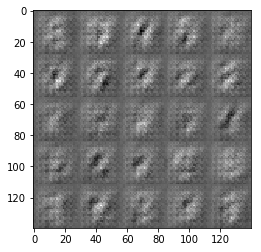

Epoch 1/2... Steps 110... Discriminator Loss: 0.6124... Generator Loss: 1.9644...
Epoch 1/2... Steps 120... Discriminator Loss: 0.8040... Generator Loss: 1.3441...
Epoch 1/2... Steps 130... Discriminator Loss: 0.6429... Generator Loss: 2.9525...
Epoch 1/2... Steps 140... Discriminator Loss: 0.6101... Generator Loss: 2.3360...
Epoch 1/2... Steps 150... Discriminator Loss: 0.6243... Generator Loss: 2.8503...
Epoch 1/2... Steps 160... Discriminator Loss: 0.5690... Generator Loss: 1.9595...
Epoch 1/2... Steps 170... Discriminator Loss: 1.2816... Generator Loss: 4.5357...
Epoch 1/2... Steps 180... Discriminator Loss: 0.6205... Generator Loss: 2.2679...
Epoch 1/2... Steps 190... Discriminator Loss: 0.5986... Generator Loss: 1.9471...
Epoch 1/2... Steps 200... Discriminator Loss: 0.9350... Generator Loss: 0.9916...


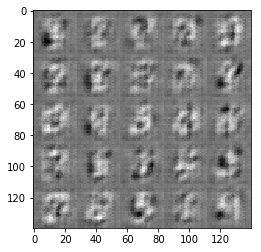

Epoch 1/2... Steps 210... Discriminator Loss: 0.9141... Generator Loss: 3.9274...
Epoch 1/2... Steps 220... Discriminator Loss: 0.7002... Generator Loss: 3.2890...
Epoch 1/2... Steps 230... Discriminator Loss: 0.5817... Generator Loss: 2.2217...
Epoch 1/2... Steps 240... Discriminator Loss: 0.5966... Generator Loss: 1.8803...
Epoch 1/2... Steps 250... Discriminator Loss: 0.5980... Generator Loss: 1.8792...
Epoch 1/2... Steps 260... Discriminator Loss: 0.9114... Generator Loss: 3.3642...
Epoch 1/2... Steps 270... Discriminator Loss: 0.7617... Generator Loss: 1.2459...
Epoch 1/2... Steps 280... Discriminator Loss: 0.5681... Generator Loss: 2.6101...
Epoch 1/2... Steps 290... Discriminator Loss: 1.0293... Generator Loss: 4.0220...
Epoch 1/2... Steps 300... Discriminator Loss: 0.6364... Generator Loss: 1.7239...


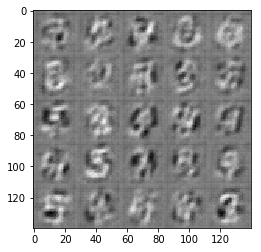

Epoch 1/2... Steps 310... Discriminator Loss: 0.5964... Generator Loss: 1.8723...
Epoch 1/2... Steps 320... Discriminator Loss: 0.6267... Generator Loss: 2.7480...
Epoch 1/2... Steps 330... Discriminator Loss: 0.5932... Generator Loss: 2.4912...
Epoch 1/2... Steps 340... Discriminator Loss: 0.6412... Generator Loss: 1.5425...
Epoch 1/2... Steps 350... Discriminator Loss: 0.5956... Generator Loss: 1.9740...
Epoch 1/2... Steps 360... Discriminator Loss: 0.6657... Generator Loss: 2.6542...
Epoch 1/2... Steps 370... Discriminator Loss: 0.5095... Generator Loss: 2.2235...
Epoch 1/2... Steps 380... Discriminator Loss: 0.7059... Generator Loss: 1.3739...
Epoch 1/2... Steps 390... Discriminator Loss: 0.5677... Generator Loss: 2.7655...
Epoch 1/2... Steps 400... Discriminator Loss: 0.6857... Generator Loss: 3.0500...


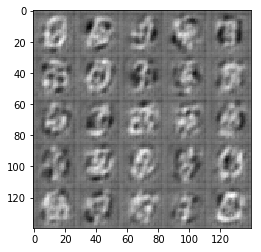

Epoch 1/2... Steps 410... Discriminator Loss: 0.7277... Generator Loss: 1.2801...
Epoch 1/2... Steps 420... Discriminator Loss: 0.7743... Generator Loss: 1.2525...
Epoch 1/2... Steps 430... Discriminator Loss: 1.1588... Generator Loss: 0.7326...
Epoch 1/2... Steps 440... Discriminator Loss: 0.5762... Generator Loss: 2.0136...
Epoch 1/2... Steps 450... Discriminator Loss: 0.6349... Generator Loss: 2.2683...
Epoch 1/2... Steps 460... Discriminator Loss: 0.6352... Generator Loss: 2.8099...
Epoch 1/2... Steps 470... Discriminator Loss: 0.6717... Generator Loss: 2.6943...
Epoch 1/2... Steps 480... Discriminator Loss: 2.1505... Generator Loss: 0.2790...
Epoch 1/2... Steps 490... Discriminator Loss: 0.6543... Generator Loss: 2.2580...
Epoch 1/2... Steps 500... Discriminator Loss: 0.6837... Generator Loss: 1.5810...


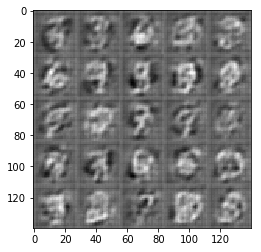

Epoch 1/2... Steps 510... Discriminator Loss: 0.6738... Generator Loss: 1.5807...
Epoch 1/2... Steps 520... Discriminator Loss: 0.6129... Generator Loss: 1.7354...
Epoch 1/2... Steps 530... Discriminator Loss: 0.6544... Generator Loss: 2.3457...
Epoch 1/2... Steps 540... Discriminator Loss: 0.6381... Generator Loss: 1.7533...
Epoch 1/2... Steps 550... Discriminator Loss: 0.7211... Generator Loss: 2.3315...
Epoch 1/2... Steps 560... Discriminator Loss: 0.6033... Generator Loss: 2.2378...
Epoch 1/2... Steps 570... Discriminator Loss: 0.6576... Generator Loss: 2.0173...
Epoch 1/2... Steps 580... Discriminator Loss: 0.6242... Generator Loss: 1.8315...
Epoch 1/2... Steps 590... Discriminator Loss: 0.7815... Generator Loss: 1.2854...
Epoch 1/2... Steps 600... Discriminator Loss: 0.7088... Generator Loss: 1.4053...


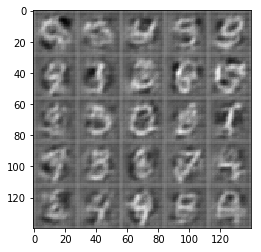

Epoch 1/2... Steps 610... Discriminator Loss: 0.6161... Generator Loss: 2.0320...
Epoch 1/2... Steps 620... Discriminator Loss: 0.7779... Generator Loss: 1.2767...
Epoch 1/2... Steps 630... Discriminator Loss: 0.7722... Generator Loss: 1.2456...
Epoch 1/2... Steps 640... Discriminator Loss: 0.6508... Generator Loss: 1.6398...
Epoch 1/2... Steps 650... Discriminator Loss: 1.4060... Generator Loss: 3.3581...
Epoch 1/2... Steps 660... Discriminator Loss: 0.6880... Generator Loss: 1.5984...
Epoch 1/2... Steps 670... Discriminator Loss: 0.6615... Generator Loss: 2.3421...
Epoch 1/2... Steps 680... Discriminator Loss: 0.6512... Generator Loss: 2.2212...
Epoch 1/2... Steps 690... Discriminator Loss: 0.6727... Generator Loss: 2.6092...
Epoch 1/2... Steps 700... Discriminator Loss: 0.6493... Generator Loss: 1.8781...


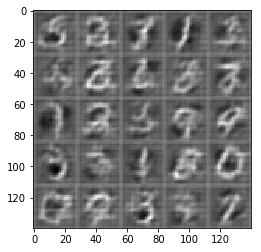

Epoch 1/2... Steps 710... Discriminator Loss: 0.7789... Generator Loss: 2.2793...
Epoch 1/2... Steps 720... Discriminator Loss: 0.8698... Generator Loss: 1.0763...
Epoch 1/2... Steps 730... Discriminator Loss: 1.0484... Generator Loss: 0.8160...
Epoch 1/2... Steps 740... Discriminator Loss: 0.8030... Generator Loss: 1.2232...
Epoch 1/2... Steps 750... Discriminator Loss: 0.6507... Generator Loss: 1.5505...
Epoch 2/2... Steps 760... Discriminator Loss: 0.9548... Generator Loss: 0.9424...
Epoch 2/2... Steps 770... Discriminator Loss: 0.7156... Generator Loss: 1.4565...
Epoch 2/2... Steps 780... Discriminator Loss: 0.7395... Generator Loss: 2.4951...
Epoch 2/2... Steps 790... Discriminator Loss: 0.7427... Generator Loss: 1.8666...
Epoch 2/2... Steps 800... Discriminator Loss: 0.7592... Generator Loss: 1.4228...


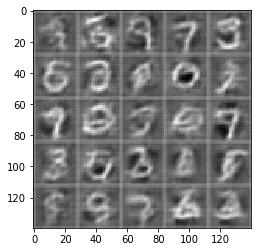

Epoch 2/2... Steps 810... Discriminator Loss: 0.6757... Generator Loss: 1.9547...
Epoch 2/2... Steps 820... Discriminator Loss: 0.7280... Generator Loss: 1.3766...
Epoch 2/2... Steps 830... Discriminator Loss: 1.0171... Generator Loss: 2.7363...
Epoch 2/2... Steps 840... Discriminator Loss: 0.7203... Generator Loss: 1.8229...
Epoch 2/2... Steps 850... Discriminator Loss: 0.8730... Generator Loss: 1.1640...
Epoch 2/2... Steps 860... Discriminator Loss: 0.7494... Generator Loss: 1.3916...
Epoch 2/2... Steps 870... Discriminator Loss: 0.6629... Generator Loss: 1.6666...
Epoch 2/2... Steps 880... Discriminator Loss: 0.7249... Generator Loss: 1.7467...
Epoch 2/2... Steps 890... Discriminator Loss: 0.8221... Generator Loss: 1.1832...
Epoch 2/2... Steps 900... Discriminator Loss: 0.7081... Generator Loss: 2.6066...


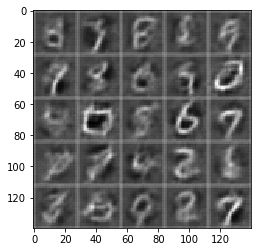

Epoch 2/2... Steps 910... Discriminator Loss: 0.9586... Generator Loss: 2.8085...
Epoch 2/2... Steps 920... Discriminator Loss: 0.8128... Generator Loss: 2.4766...
Epoch 2/2... Steps 930... Discriminator Loss: 0.8727... Generator Loss: 1.0710...
Epoch 2/2... Steps 940... Discriminator Loss: 0.6683... Generator Loss: 1.9198...
Epoch 2/2... Steps 950... Discriminator Loss: 1.1011... Generator Loss: 0.9647...
Epoch 2/2... Steps 960... Discriminator Loss: 0.7698... Generator Loss: 1.3842...
Epoch 2/2... Steps 970... Discriminator Loss: 0.6213... Generator Loss: 2.1320...
Epoch 2/2... Steps 980... Discriminator Loss: 0.7093... Generator Loss: 1.3877...
Epoch 2/2... Steps 990... Discriminator Loss: 0.7134... Generator Loss: 1.6899...
Epoch 2/2... Steps 1000... Discriminator Loss: 0.6625... Generator Loss: 1.5658...


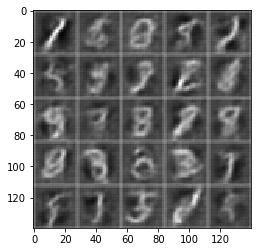

Epoch 2/2... Steps 1010... Discriminator Loss: 0.9580... Generator Loss: 0.9006...
Epoch 2/2... Steps 1020... Discriminator Loss: 0.7730... Generator Loss: 1.8762...
Epoch 2/2... Steps 1030... Discriminator Loss: 0.6819... Generator Loss: 1.5008...
Epoch 2/2... Steps 1040... Discriminator Loss: 0.6367... Generator Loss: 1.6573...
Epoch 2/2... Steps 1050... Discriminator Loss: 0.7204... Generator Loss: 1.5468...
Epoch 2/2... Steps 1060... Discriminator Loss: 0.6703... Generator Loss: 1.5008...
Epoch 2/2... Steps 1070... Discriminator Loss: 0.7386... Generator Loss: 1.4222...
Epoch 2/2... Steps 1080... Discriminator Loss: 0.7549... Generator Loss: 1.9139...
Epoch 2/2... Steps 1090... Discriminator Loss: 0.7223... Generator Loss: 1.4048...
Epoch 2/2... Steps 1100... Discriminator Loss: 0.7133... Generator Loss: 1.3723...


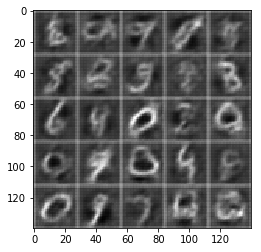

Epoch 2/2... Steps 1110... Discriminator Loss: 0.7230... Generator Loss: 1.6100...
Epoch 2/2... Steps 1120... Discriminator Loss: 1.5437... Generator Loss: 0.4938...
Epoch 2/2... Steps 1130... Discriminator Loss: 0.8109... Generator Loss: 1.1987...
Epoch 2/2... Steps 1140... Discriminator Loss: 0.7642... Generator Loss: 1.5260...
Epoch 2/2... Steps 1150... Discriminator Loss: 0.6379... Generator Loss: 1.6936...
Epoch 2/2... Steps 1160... Discriminator Loss: 0.7783... Generator Loss: 1.2036...
Epoch 2/2... Steps 1170... Discriminator Loss: 0.7088... Generator Loss: 1.3593...
Epoch 2/2... Steps 1180... Discriminator Loss: 0.7069... Generator Loss: 1.4571...
Epoch 2/2... Steps 1190... Discriminator Loss: 0.7003... Generator Loss: 1.4286...
Epoch 2/2... Steps 1200... Discriminator Loss: 0.8600... Generator Loss: 1.0476...


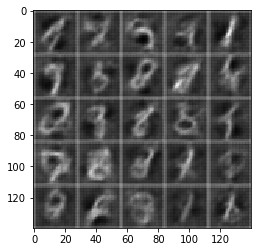

Epoch 2/2... Steps 1210... Discriminator Loss: 0.6044... Generator Loss: 2.2325...
Epoch 2/2... Steps 1220... Discriminator Loss: 0.9539... Generator Loss: 0.9219...
Epoch 2/2... Steps 1230... Discriminator Loss: 0.7159... Generator Loss: 1.4401...
Epoch 2/2... Steps 1240... Discriminator Loss: 0.6898... Generator Loss: 1.9429...
Epoch 2/2... Steps 1250... Discriminator Loss: 1.1938... Generator Loss: 0.6884...
Epoch 2/2... Steps 1260... Discriminator Loss: 0.7324... Generator Loss: 1.5715...
Epoch 2/2... Steps 1270... Discriminator Loss: 0.7548... Generator Loss: 1.5214...
Epoch 2/2... Steps 1280... Discriminator Loss: 0.6547... Generator Loss: 1.7683...
Epoch 2/2... Steps 1290... Discriminator Loss: 0.9076... Generator Loss: 0.9647...
Epoch 2/2... Steps 1300... Discriminator Loss: 0.6605... Generator Loss: 1.8117...


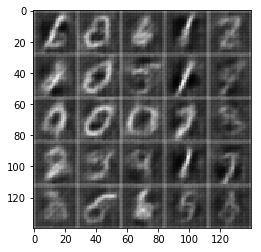

Epoch 2/2... Steps 1310... Discriminator Loss: 0.5991... Generator Loss: 2.0177...
Epoch 2/2... Steps 1320... Discriminator Loss: 0.6922... Generator Loss: 1.9205...
Epoch 2/2... Steps 1330... Discriminator Loss: 0.7153... Generator Loss: 1.3122...
Epoch 2/2... Steps 1340... Discriminator Loss: 0.8228... Generator Loss: 1.1566...
Epoch 2/2... Steps 1350... Discriminator Loss: 0.7630... Generator Loss: 2.4568...
Epoch 2/2... Steps 1360... Discriminator Loss: 0.6656... Generator Loss: 1.7158...
Epoch 2/2... Steps 1370... Discriminator Loss: 0.7438... Generator Loss: 1.3053...
Epoch 2/2... Steps 1380... Discriminator Loss: 0.7742... Generator Loss: 1.2745...
Epoch 2/2... Steps 1390... Discriminator Loss: 0.6498... Generator Loss: 1.5732...
Epoch 2/2... Steps 1400... Discriminator Loss: 0.9219... Generator Loss: 1.4310...


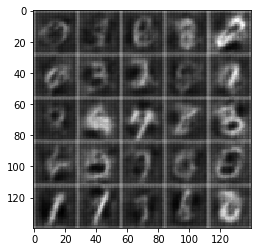

Epoch 2/2... Steps 1410... Discriminator Loss: 0.6749... Generator Loss: 1.8558...
Epoch 2/2... Steps 1420... Discriminator Loss: 0.8091... Generator Loss: 1.1709...
Epoch 2/2... Steps 1430... Discriminator Loss: 0.8913... Generator Loss: 1.0635...
Epoch 2/2... Steps 1440... Discriminator Loss: 0.6885... Generator Loss: 1.5736...
Epoch 2/2... Steps 1450... Discriminator Loss: 0.7072... Generator Loss: 1.5278...
Epoch 2/2... Steps 1460... Discriminator Loss: 0.8780... Generator Loss: 1.0539...
Epoch 2/2... Steps 1470... Discriminator Loss: 0.6182... Generator Loss: 2.0154...
Epoch 2/2... Steps 1480... Discriminator Loss: 0.7646... Generator Loss: 1.2281...
Epoch 2/2... Steps 1490... Discriminator Loss: 0.8113... Generator Loss: 3.0039...
Epoch 2/2... Steps 1500... Discriminator Loss: 1.4079... Generator Loss: 0.5414...


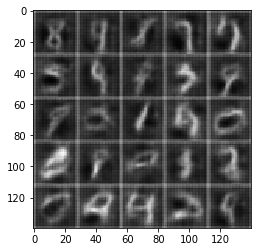

In [19]:
batch_size = 80
z_dim = 100
learning_rate = 0.0002
beta1 = 0.6


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Steps 10... Discriminator Loss: 0.7481... Generator Loss: 1.4926...
Epoch 1/1... Steps 20... Discriminator Loss: 0.5359... Generator Loss: 2.4548...
Epoch 1/1... Steps 30... Discriminator Loss: 0.5935... Generator Loss: 2.2161...
Epoch 1/1... Steps 40... Discriminator Loss: 0.4633... Generator Loss: 2.9965...
Epoch 1/1... Steps 50... Discriminator Loss: 1.3258... Generator Loss: 8.0761...
Epoch 1/1... Steps 60... Discriminator Loss: 1.6958... Generator Loss: 0.6419...
Epoch 1/1... Steps 70... Discriminator Loss: 0.8733... Generator Loss: 3.4097...
Epoch 1/1... Steps 80... Discriminator Loss: 1.2536... Generator Loss: 2.8868...
Epoch 1/1... Steps 90... Discriminator Loss: 0.8913... Generator Loss: 1.6776...
Epoch 1/1... Steps 100... Discriminator Loss: 1.1866... Generator Loss: 0.7829...


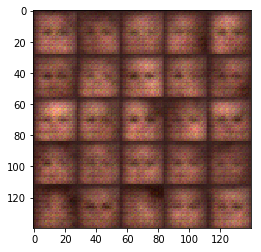

Epoch 1/1... Steps 110... Discriminator Loss: 1.1842... Generator Loss: 0.6767...
Epoch 1/1... Steps 120... Discriminator Loss: 1.0100... Generator Loss: 3.1884...
Epoch 1/1... Steps 130... Discriminator Loss: 0.7444... Generator Loss: 1.6801...
Epoch 1/1... Steps 140... Discriminator Loss: 0.7136... Generator Loss: 1.9562...
Epoch 1/1... Steps 150... Discriminator Loss: 0.6788... Generator Loss: 1.9441...
Epoch 1/1... Steps 160... Discriminator Loss: 1.0055... Generator Loss: 1.3093...
Epoch 1/1... Steps 170... Discriminator Loss: 0.8049... Generator Loss: 1.9101...
Epoch 1/1... Steps 180... Discriminator Loss: 0.7944... Generator Loss: 2.1366...
Epoch 1/1... Steps 190... Discriminator Loss: 1.0325... Generator Loss: 4.2439...
Epoch 1/1... Steps 200... Discriminator Loss: 0.9653... Generator Loss: 1.1026...


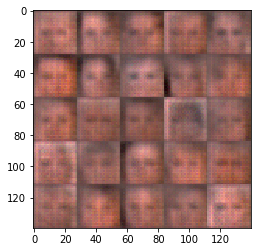

Epoch 1/1... Steps 210... Discriminator Loss: 1.2810... Generator Loss: 0.7018...
Epoch 1/1... Steps 220... Discriminator Loss: 1.6129... Generator Loss: 3.9405...
Epoch 1/1... Steps 230... Discriminator Loss: 1.0013... Generator Loss: 1.0033...
Epoch 1/1... Steps 240... Discriminator Loss: 1.5464... Generator Loss: 0.4418...
Epoch 1/1... Steps 250... Discriminator Loss: 1.1817... Generator Loss: 0.7808...
Epoch 1/1... Steps 260... Discriminator Loss: 1.0035... Generator Loss: 0.9903...
Epoch 1/1... Steps 270... Discriminator Loss: 1.1617... Generator Loss: 0.7397...
Epoch 1/1... Steps 280... Discriminator Loss: 0.7283... Generator Loss: 1.4701...
Epoch 1/1... Steps 290... Discriminator Loss: 1.1865... Generator Loss: 1.5239...
Epoch 1/1... Steps 300... Discriminator Loss: 0.8768... Generator Loss: 2.2101...


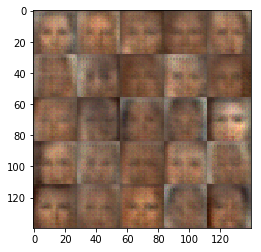

Epoch 1/1... Steps 310... Discriminator Loss: 0.8800... Generator Loss: 1.9104...
Epoch 1/1... Steps 320... Discriminator Loss: 1.1907... Generator Loss: 0.8580...
Epoch 1/1... Steps 330... Discriminator Loss: 1.3967... Generator Loss: 0.5950...
Epoch 1/1... Steps 340... Discriminator Loss: 1.0450... Generator Loss: 1.9311...
Epoch 1/1... Steps 350... Discriminator Loss: 1.0480... Generator Loss: 1.2138...
Epoch 1/1... Steps 360... Discriminator Loss: 1.2354... Generator Loss: 1.7538...
Epoch 1/1... Steps 370... Discriminator Loss: 0.9421... Generator Loss: 1.1815...
Epoch 1/1... Steps 380... Discriminator Loss: 0.9966... Generator Loss: 1.2705...
Epoch 1/1... Steps 390... Discriminator Loss: 1.3668... Generator Loss: 2.6046...
Epoch 1/1... Steps 400... Discriminator Loss: 0.9448... Generator Loss: 1.7924...


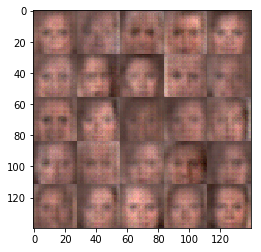

Epoch 1/1... Steps 410... Discriminator Loss: 1.2379... Generator Loss: 1.2243...
Epoch 1/1... Steps 420... Discriminator Loss: 1.1106... Generator Loss: 1.0010...
Epoch 1/1... Steps 430... Discriminator Loss: 1.3118... Generator Loss: 0.6409...
Epoch 1/1... Steps 440... Discriminator Loss: 1.1270... Generator Loss: 1.3791...
Epoch 1/1... Steps 450... Discriminator Loss: 1.3679... Generator Loss: 0.8462...
Epoch 1/1... Steps 460... Discriminator Loss: 1.1286... Generator Loss: 0.9782...
Epoch 1/1... Steps 470... Discriminator Loss: 1.2256... Generator Loss: 1.1369...
Epoch 1/1... Steps 480... Discriminator Loss: 1.1845... Generator Loss: 0.9941...
Epoch 1/1... Steps 490... Discriminator Loss: 1.2015... Generator Loss: 0.7536...
Epoch 1/1... Steps 500... Discriminator Loss: 1.1346... Generator Loss: 1.3782...


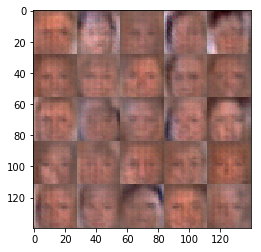

Epoch 1/1... Steps 510... Discriminator Loss: 1.3216... Generator Loss: 1.4935...
Epoch 1/1... Steps 520... Discriminator Loss: 1.2433... Generator Loss: 0.8051...
Epoch 1/1... Steps 530... Discriminator Loss: 1.1646... Generator Loss: 0.9362...
Epoch 1/1... Steps 540... Discriminator Loss: 1.3420... Generator Loss: 0.6031...
Epoch 1/1... Steps 550... Discriminator Loss: 1.1848... Generator Loss: 1.1581...
Epoch 1/1... Steps 560... Discriminator Loss: 1.3764... Generator Loss: 0.5645...
Epoch 1/1... Steps 570... Discriminator Loss: 1.0564... Generator Loss: 1.2111...
Epoch 1/1... Steps 580... Discriminator Loss: 1.4005... Generator Loss: 0.5572...
Epoch 1/1... Steps 590... Discriminator Loss: 1.0986... Generator Loss: 1.4746...
Epoch 1/1... Steps 600... Discriminator Loss: 1.2956... Generator Loss: 0.7827...


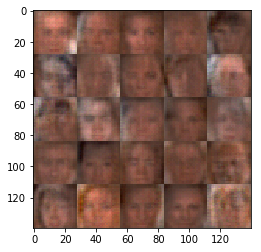

Epoch 1/1... Steps 610... Discriminator Loss: 1.1833... Generator Loss: 1.5260...
Epoch 1/1... Steps 620... Discriminator Loss: 1.2527... Generator Loss: 0.9779...
Epoch 1/1... Steps 630... Discriminator Loss: 1.9342... Generator Loss: 2.8872...
Epoch 1/1... Steps 640... Discriminator Loss: 0.9991... Generator Loss: 1.0924...
Epoch 1/1... Steps 650... Discriminator Loss: 1.2465... Generator Loss: 0.7652...
Epoch 1/1... Steps 660... Discriminator Loss: 1.3114... Generator Loss: 0.6428...
Epoch 1/1... Steps 670... Discriminator Loss: 1.0916... Generator Loss: 1.0439...
Epoch 1/1... Steps 680... Discriminator Loss: 1.1702... Generator Loss: 1.3989...
Epoch 1/1... Steps 690... Discriminator Loss: 1.1534... Generator Loss: 1.0333...
Epoch 1/1... Steps 700... Discriminator Loss: 1.1530... Generator Loss: 1.0959...


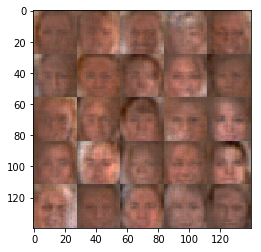

Epoch 1/1... Steps 710... Discriminator Loss: 1.0725... Generator Loss: 1.3830...
Epoch 1/1... Steps 720... Discriminator Loss: 1.2246... Generator Loss: 1.2273...
Epoch 1/1... Steps 730... Discriminator Loss: 1.5872... Generator Loss: 0.4299...
Epoch 1/1... Steps 740... Discriminator Loss: 1.2298... Generator Loss: 0.9101...
Epoch 1/1... Steps 750... Discriminator Loss: 1.1198... Generator Loss: 1.4012...
Epoch 1/1... Steps 760... Discriminator Loss: 1.1450... Generator Loss: 0.8091...
Epoch 1/1... Steps 770... Discriminator Loss: 1.2777... Generator Loss: 1.7445...
Epoch 1/1... Steps 780... Discriminator Loss: 1.1766... Generator Loss: 0.8980...
Epoch 1/1... Steps 790... Discriminator Loss: 1.2146... Generator Loss: 0.7582...
Epoch 1/1... Steps 800... Discriminator Loss: 1.1363... Generator Loss: 0.9188...


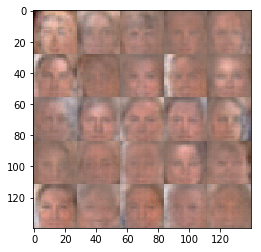

Epoch 1/1... Steps 810... Discriminator Loss: 1.1098... Generator Loss: 1.0505...
Epoch 1/1... Steps 820... Discriminator Loss: 1.2000... Generator Loss: 0.7852...
Epoch 1/1... Steps 830... Discriminator Loss: 1.4411... Generator Loss: 0.6261...
Epoch 1/1... Steps 840... Discriminator Loss: 1.3200... Generator Loss: 1.3098...
Epoch 1/1... Steps 850... Discriminator Loss: 1.1719... Generator Loss: 1.0765...
Epoch 1/1... Steps 860... Discriminator Loss: 1.1505... Generator Loss: 1.1115...
Epoch 1/1... Steps 870... Discriminator Loss: 1.1765... Generator Loss: 0.9979...
Epoch 1/1... Steps 880... Discriminator Loss: 1.1050... Generator Loss: 1.3938...
Epoch 1/1... Steps 890... Discriminator Loss: 1.2277... Generator Loss: 0.8157...
Epoch 1/1... Steps 900... Discriminator Loss: 1.0375... Generator Loss: 1.0635...


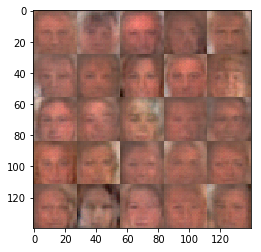

Epoch 1/1... Steps 910... Discriminator Loss: 1.0432... Generator Loss: 1.3303...
Epoch 1/1... Steps 920... Discriminator Loss: 1.0868... Generator Loss: 1.0160...
Epoch 1/1... Steps 930... Discriminator Loss: 1.1664... Generator Loss: 0.8229...
Epoch 1/1... Steps 940... Discriminator Loss: 1.1193... Generator Loss: 1.0670...
Epoch 1/1... Steps 950... Discriminator Loss: 1.1279... Generator Loss: 0.8759...
Epoch 1/1... Steps 960... Discriminator Loss: 1.1285... Generator Loss: 1.0012...
Epoch 1/1... Steps 970... Discriminator Loss: 1.1938... Generator Loss: 0.7203...
Epoch 1/1... Steps 980... Discriminator Loss: 1.1706... Generator Loss: 0.7886...
Epoch 1/1... Steps 990... Discriminator Loss: 1.1669... Generator Loss: 0.8409...
Epoch 1/1... Steps 1000... Discriminator Loss: 1.0363... Generator Loss: 1.2589...


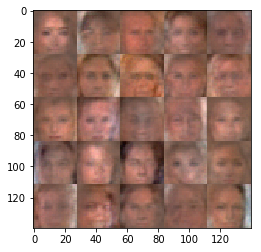

Epoch 1/1... Steps 1010... Discriminator Loss: 1.0742... Generator Loss: 1.3197...
Epoch 1/1... Steps 1020... Discriminator Loss: 1.0444... Generator Loss: 1.2522...
Epoch 1/1... Steps 1030... Discriminator Loss: 1.1441... Generator Loss: 1.1826...
Epoch 1/1... Steps 1040... Discriminator Loss: 1.2326... Generator Loss: 1.6369...
Epoch 1/1... Steps 1050... Discriminator Loss: 1.0416... Generator Loss: 1.0794...
Epoch 1/1... Steps 1060... Discriminator Loss: 1.1415... Generator Loss: 0.8206...
Epoch 1/1... Steps 1070... Discriminator Loss: 1.1148... Generator Loss: 1.0119...
Epoch 1/1... Steps 1080... Discriminator Loss: 1.1586... Generator Loss: 0.7991...
Epoch 1/1... Steps 1090... Discriminator Loss: 0.9798... Generator Loss: 1.1994...
Epoch 1/1... Steps 1100... Discriminator Loss: 1.1806... Generator Loss: 0.7838...


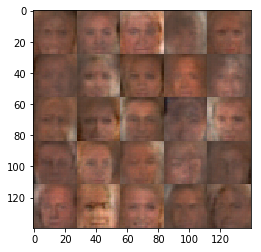

Epoch 1/1... Steps 1110... Discriminator Loss: 1.1635... Generator Loss: 0.9049...
Epoch 1/1... Steps 1120... Discriminator Loss: 1.2438... Generator Loss: 0.6656...
Epoch 1/1... Steps 1130... Discriminator Loss: 0.9849... Generator Loss: 1.0969...
Epoch 1/1... Steps 1140... Discriminator Loss: 1.0681... Generator Loss: 1.1091...
Epoch 1/1... Steps 1150... Discriminator Loss: 1.0032... Generator Loss: 1.1337...
Epoch 1/1... Steps 1160... Discriminator Loss: 1.2349... Generator Loss: 0.7387...
Epoch 1/1... Steps 1170... Discriminator Loss: 0.9512... Generator Loss: 1.3202...
Epoch 1/1... Steps 1180... Discriminator Loss: 0.8460... Generator Loss: 1.3724...
Epoch 1/1... Steps 1190... Discriminator Loss: 1.0407... Generator Loss: 0.9236...
Epoch 1/1... Steps 1200... Discriminator Loss: 0.9396... Generator Loss: 1.2246...


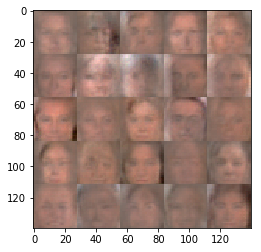

Epoch 1/1... Steps 1210... Discriminator Loss: 1.2193... Generator Loss: 0.7833...
Epoch 1/1... Steps 1220... Discriminator Loss: 1.2129... Generator Loss: 1.5308...
Epoch 1/1... Steps 1230... Discriminator Loss: 1.3304... Generator Loss: 0.5858...
Epoch 1/1... Steps 1240... Discriminator Loss: 1.1292... Generator Loss: 1.0837...
Epoch 1/1... Steps 1250... Discriminator Loss: 1.1477... Generator Loss: 1.1626...
Epoch 1/1... Steps 1260... Discriminator Loss: 1.1260... Generator Loss: 0.8069...
Epoch 1/1... Steps 1270... Discriminator Loss: 0.9801... Generator Loss: 1.2874...
Epoch 1/1... Steps 1280... Discriminator Loss: 1.2811... Generator Loss: 0.6135...
Epoch 1/1... Steps 1290... Discriminator Loss: 1.7838... Generator Loss: 0.3394...
Epoch 1/1... Steps 1300... Discriminator Loss: 1.1540... Generator Loss: 0.7343...


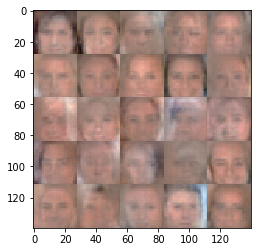

Epoch 1/1... Steps 1310... Discriminator Loss: 1.0629... Generator Loss: 1.0715...
Epoch 1/1... Steps 1320... Discriminator Loss: 1.1454... Generator Loss: 0.8851...
Epoch 1/1... Steps 1330... Discriminator Loss: 1.1604... Generator Loss: 0.9176...
Epoch 1/1... Steps 1340... Discriminator Loss: 1.3266... Generator Loss: 0.7039...
Epoch 1/1... Steps 1350... Discriminator Loss: 1.1654... Generator Loss: 0.8597...
Epoch 1/1... Steps 1360... Discriminator Loss: 1.1844... Generator Loss: 1.1994...
Epoch 1/1... Steps 1370... Discriminator Loss: 0.8491... Generator Loss: 1.6871...
Epoch 1/1... Steps 1380... Discriminator Loss: 1.0771... Generator Loss: 0.8956...
Epoch 1/1... Steps 1390... Discriminator Loss: 1.1417... Generator Loss: 1.3539...
Epoch 1/1... Steps 1400... Discriminator Loss: 0.9888... Generator Loss: 1.1069...


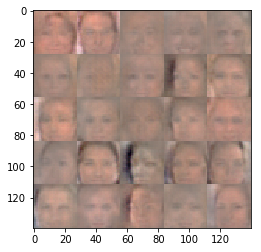

Epoch 1/1... Steps 1410... Discriminator Loss: 0.9895... Generator Loss: 0.9609...
Epoch 1/1... Steps 1420... Discriminator Loss: 1.0260... Generator Loss: 1.2384...
Epoch 1/1... Steps 1430... Discriminator Loss: 1.1064... Generator Loss: 0.9825...
Epoch 1/1... Steps 1440... Discriminator Loss: 1.1102... Generator Loss: 1.1722...
Epoch 1/1... Steps 1450... Discriminator Loss: 1.1741... Generator Loss: 0.7449...
Epoch 1/1... Steps 1460... Discriminator Loss: 0.7969... Generator Loss: 1.5501...
Epoch 1/1... Steps 1470... Discriminator Loss: 1.0565... Generator Loss: 1.0751...
Epoch 1/1... Steps 1480... Discriminator Loss: 1.0773... Generator Loss: 1.0645...
Epoch 1/1... Steps 1490... Discriminator Loss: 0.9813... Generator Loss: 1.2058...
Epoch 1/1... Steps 1500... Discriminator Loss: 1.3278... Generator Loss: 1.3438...


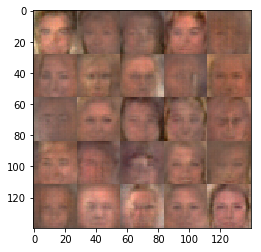

Epoch 1/1... Steps 1510... Discriminator Loss: 1.3294... Generator Loss: 1.0344...
Epoch 1/1... Steps 1520... Discriminator Loss: 1.0837... Generator Loss: 0.9502...
Epoch 1/1... Steps 1530... Discriminator Loss: 1.1385... Generator Loss: 0.9627...
Epoch 1/1... Steps 1540... Discriminator Loss: 1.2429... Generator Loss: 0.7668...
Epoch 1/1... Steps 1550... Discriminator Loss: 1.1952... Generator Loss: 0.7509...
Epoch 1/1... Steps 1560... Discriminator Loss: 1.2044... Generator Loss: 0.8052...
Epoch 1/1... Steps 1570... Discriminator Loss: 1.1862... Generator Loss: 0.8827...
Epoch 1/1... Steps 1580... Discriminator Loss: 1.3012... Generator Loss: 0.6347...
Epoch 1/1... Steps 1590... Discriminator Loss: 1.3638... Generator Loss: 0.6246...
Epoch 1/1... Steps 1600... Discriminator Loss: 1.1711... Generator Loss: 1.6075...


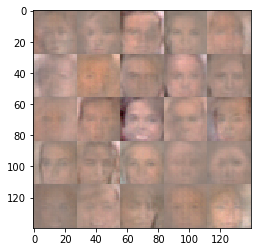

Epoch 1/1... Steps 1610... Discriminator Loss: 1.3851... Generator Loss: 0.8348...
Epoch 1/1... Steps 1620... Discriminator Loss: 1.2776... Generator Loss: 0.8200...
Epoch 1/1... Steps 1630... Discriminator Loss: 1.1287... Generator Loss: 0.9687...
Epoch 1/1... Steps 1640... Discriminator Loss: 1.1537... Generator Loss: 1.5425...
Epoch 1/1... Steps 1650... Discriminator Loss: 1.0987... Generator Loss: 1.0070...
Epoch 1/1... Steps 1660... Discriminator Loss: 1.0719... Generator Loss: 0.8401...
Epoch 1/1... Steps 1670... Discriminator Loss: 0.9793... Generator Loss: 1.1913...
Epoch 1/1... Steps 1680... Discriminator Loss: 1.1397... Generator Loss: 1.0114...
Epoch 1/1... Steps 1690... Discriminator Loss: 1.0081... Generator Loss: 1.0649...
Epoch 1/1... Steps 1700... Discriminator Loss: 1.2052... Generator Loss: 0.6929...


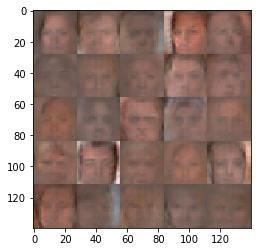

Epoch 1/1... Steps 1710... Discriminator Loss: 1.0707... Generator Loss: 0.9836...
Epoch 1/1... Steps 1720... Discriminator Loss: 1.1410... Generator Loss: 0.9432...
Epoch 1/1... Steps 1730... Discriminator Loss: 1.1251... Generator Loss: 1.3623...
Epoch 1/1... Steps 1740... Discriminator Loss: 1.0507... Generator Loss: 1.4768...
Epoch 1/1... Steps 1750... Discriminator Loss: 1.3491... Generator Loss: 0.5355...
Epoch 1/1... Steps 1760... Discriminator Loss: 1.1201... Generator Loss: 1.0446...
Epoch 1/1... Steps 1770... Discriminator Loss: 1.0342... Generator Loss: 0.9820...
Epoch 1/1... Steps 1780... Discriminator Loss: 1.2472... Generator Loss: 0.7128...
Epoch 1/1... Steps 1790... Discriminator Loss: 1.3144... Generator Loss: 0.7771...
Epoch 1/1... Steps 1800... Discriminator Loss: 1.1239... Generator Loss: 1.1626...


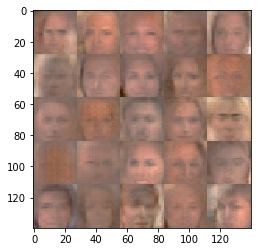

Epoch 1/1... Steps 1810... Discriminator Loss: 1.3371... Generator Loss: 1.1616...
Epoch 1/1... Steps 1820... Discriminator Loss: 1.1863... Generator Loss: 0.8628...
Epoch 1/1... Steps 1830... Discriminator Loss: 1.3865... Generator Loss: 0.5516...
Epoch 1/1... Steps 1840... Discriminator Loss: 1.0390... Generator Loss: 1.0037...
Epoch 1/1... Steps 1850... Discriminator Loss: 1.7059... Generator Loss: 0.4005...
Epoch 1/1... Steps 1860... Discriminator Loss: 1.3558... Generator Loss: 0.7550...
Epoch 1/1... Steps 1870... Discriminator Loss: 1.1556... Generator Loss: 1.3424...
Epoch 1/1... Steps 1880... Discriminator Loss: 1.0328... Generator Loss: 1.1166...
Epoch 1/1... Steps 1890... Discriminator Loss: 1.0452... Generator Loss: 1.3944...
Epoch 1/1... Steps 1900... Discriminator Loss: 1.1010... Generator Loss: 1.3567...


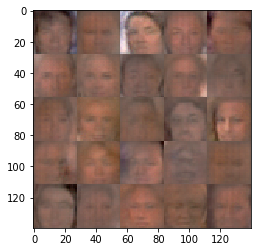

Epoch 1/1... Steps 1910... Discriminator Loss: 1.1919... Generator Loss: 0.7933...
Epoch 1/1... Steps 1920... Discriminator Loss: 1.1850... Generator Loss: 0.7299...
Epoch 1/1... Steps 1930... Discriminator Loss: 0.8514... Generator Loss: 1.1606...
Epoch 1/1... Steps 1940... Discriminator Loss: 1.0255... Generator Loss: 0.9625...
Epoch 1/1... Steps 1950... Discriminator Loss: 1.2143... Generator Loss: 0.7415...
Epoch 1/1... Steps 1960... Discriminator Loss: 1.1139... Generator Loss: 1.4160...
Epoch 1/1... Steps 1970... Discriminator Loss: 1.2000... Generator Loss: 0.8146...
Epoch 1/1... Steps 1980... Discriminator Loss: 1.2083... Generator Loss: 0.8580...
Epoch 1/1... Steps 1990... Discriminator Loss: 1.4149... Generator Loss: 0.5059...
Epoch 1/1... Steps 2000... Discriminator Loss: 1.0450... Generator Loss: 0.8533...


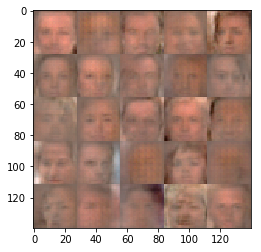

Epoch 1/1... Steps 2010... Discriminator Loss: 0.9045... Generator Loss: 1.3827...
Epoch 1/1... Steps 2020... Discriminator Loss: 0.8967... Generator Loss: 1.0603...
Epoch 1/1... Steps 2030... Discriminator Loss: 1.8009... Generator Loss: 0.3303...
Epoch 1/1... Steps 2040... Discriminator Loss: 1.3272... Generator Loss: 1.2044...
Epoch 1/1... Steps 2050... Discriminator Loss: 1.2434... Generator Loss: 1.0054...
Epoch 1/1... Steps 2060... Discriminator Loss: 1.0364... Generator Loss: 1.2453...
Epoch 1/1... Steps 2070... Discriminator Loss: 1.1159... Generator Loss: 0.9751...
Epoch 1/1... Steps 2080... Discriminator Loss: 0.8698... Generator Loss: 1.2018...
Epoch 1/1... Steps 2090... Discriminator Loss: 1.0359... Generator Loss: 1.1090...
Epoch 1/1... Steps 2100... Discriminator Loss: 1.2454... Generator Loss: 1.5537...


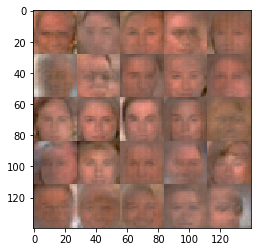

Epoch 1/1... Steps 2110... Discriminator Loss: 1.0596... Generator Loss: 0.8485...
Epoch 1/1... Steps 2120... Discriminator Loss: 1.0617... Generator Loss: 0.9485...
Epoch 1/1... Steps 2130... Discriminator Loss: 0.8377... Generator Loss: 1.8357...
Epoch 1/1... Steps 2140... Discriminator Loss: 1.0352... Generator Loss: 0.8982...
Epoch 1/1... Steps 2150... Discriminator Loss: 1.0849... Generator Loss: 0.9017...
Epoch 1/1... Steps 2160... Discriminator Loss: 0.9944... Generator Loss: 1.0205...
Epoch 1/1... Steps 2170... Discriminator Loss: 1.0175... Generator Loss: 1.0774...
Epoch 1/1... Steps 2180... Discriminator Loss: 1.3756... Generator Loss: 0.5634...
Epoch 1/1... Steps 2190... Discriminator Loss: 1.1539... Generator Loss: 0.8135...
Epoch 1/1... Steps 2200... Discriminator Loss: 1.0419... Generator Loss: 1.4387...


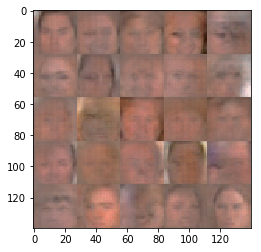

Epoch 1/1... Steps 2210... Discriminator Loss: 1.2313... Generator Loss: 0.7750...
Epoch 1/1... Steps 2220... Discriminator Loss: 0.8276... Generator Loss: 1.3768...
Epoch 1/1... Steps 2230... Discriminator Loss: 1.3402... Generator Loss: 0.5107...
Epoch 1/1... Steps 2240... Discriminator Loss: 1.0449... Generator Loss: 1.0395...
Epoch 1/1... Steps 2250... Discriminator Loss: 0.9646... Generator Loss: 1.1624...
Epoch 1/1... Steps 2260... Discriminator Loss: 1.2308... Generator Loss: 0.6563...
Epoch 1/1... Steps 2270... Discriminator Loss: 1.0729... Generator Loss: 0.8190...
Epoch 1/1... Steps 2280... Discriminator Loss: 1.3148... Generator Loss: 0.6772...
Epoch 1/1... Steps 2290... Discriminator Loss: 0.9863... Generator Loss: 1.1591...
Epoch 1/1... Steps 2300... Discriminator Loss: 1.0853... Generator Loss: 0.8335...


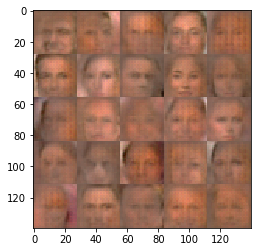

Epoch 1/1... Steps 2310... Discriminator Loss: 1.1496... Generator Loss: 1.1902...
Epoch 1/1... Steps 2320... Discriminator Loss: 1.1337... Generator Loss: 0.7738...
Epoch 1/1... Steps 2330... Discriminator Loss: 1.0907... Generator Loss: 0.7941...
Epoch 1/1... Steps 2340... Discriminator Loss: 1.0884... Generator Loss: 1.0666...
Epoch 1/1... Steps 2350... Discriminator Loss: 0.9648... Generator Loss: 1.0623...
Epoch 1/1... Steps 2360... Discriminator Loss: 1.0276... Generator Loss: 1.0422...
Epoch 1/1... Steps 2370... Discriminator Loss: 1.0522... Generator Loss: 0.8096...
Epoch 1/1... Steps 2380... Discriminator Loss: 0.9186... Generator Loss: 1.0895...
Epoch 1/1... Steps 2390... Discriminator Loss: 1.1028... Generator Loss: 0.8084...
Epoch 1/1... Steps 2400... Discriminator Loss: 1.2743... Generator Loss: 0.6719...


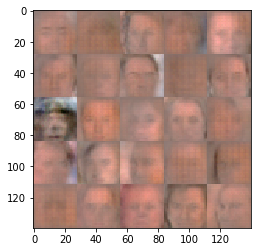

Epoch 1/1... Steps 2410... Discriminator Loss: 1.1343... Generator Loss: 0.7736...
Epoch 1/1... Steps 2420... Discriminator Loss: 0.9794... Generator Loss: 1.3428...
Epoch 1/1... Steps 2430... Discriminator Loss: 1.2421... Generator Loss: 0.5648...
Epoch 1/1... Steps 2440... Discriminator Loss: 1.3906... Generator Loss: 0.5473...
Epoch 1/1... Steps 2450... Discriminator Loss: 1.1986... Generator Loss: 0.6646...
Epoch 1/1... Steps 2460... Discriminator Loss: 1.3191... Generator Loss: 0.5649...
Epoch 1/1... Steps 2470... Discriminator Loss: 1.0971... Generator Loss: 0.8218...
Epoch 1/1... Steps 2480... Discriminator Loss: 1.1734... Generator Loss: 0.6313...
Epoch 1/1... Steps 2490... Discriminator Loss: 1.1416... Generator Loss: 0.7677...
Epoch 1/1... Steps 2500... Discriminator Loss: 1.2857... Generator Loss: 0.7523...


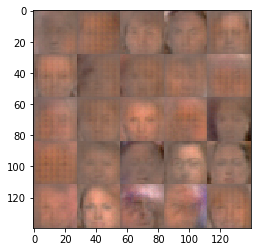

Epoch 1/1... Steps 2510... Discriminator Loss: 1.1625... Generator Loss: 0.7468...
Epoch 1/1... Steps 2520... Discriminator Loss: 0.9316... Generator Loss: 1.2155...
Epoch 1/1... Steps 2530... Discriminator Loss: 1.2735... Generator Loss: 0.6652...
Epoch 1/1... Steps 2540... Discriminator Loss: 1.2296... Generator Loss: 1.2232...
Epoch 1/1... Steps 2550... Discriminator Loss: 0.9903... Generator Loss: 1.0631...
Epoch 1/1... Steps 2560... Discriminator Loss: 1.0180... Generator Loss: 1.1034...
Epoch 1/1... Steps 2570... Discriminator Loss: 1.0479... Generator Loss: 1.2112...
Epoch 1/1... Steps 2580... Discriminator Loss: 1.0080... Generator Loss: 1.1653...
Epoch 1/1... Steps 2590... Discriminator Loss: 0.9906... Generator Loss: 1.0437...
Epoch 1/1... Steps 2600... Discriminator Loss: 0.9823... Generator Loss: 1.1692...


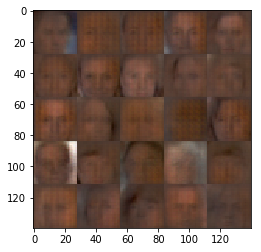

Epoch 1/1... Steps 2610... Discriminator Loss: 1.1138... Generator Loss: 0.8462...
Epoch 1/1... Steps 2620... Discriminator Loss: 1.2684... Generator Loss: 0.6598...
Epoch 1/1... Steps 2630... Discriminator Loss: 1.2643... Generator Loss: 0.6569...
Epoch 1/1... Steps 2640... Discriminator Loss: 1.1484... Generator Loss: 1.2035...
Epoch 1/1... Steps 2650... Discriminator Loss: 0.9973... Generator Loss: 0.9515...
Epoch 1/1... Steps 2660... Discriminator Loss: 0.8634... Generator Loss: 1.2064...
Epoch 1/1... Steps 2670... Discriminator Loss: 0.9370... Generator Loss: 1.4689...
Epoch 1/1... Steps 2680... Discriminator Loss: 1.2423... Generator Loss: 0.7793...
Epoch 1/1... Steps 2690... Discriminator Loss: 1.1363... Generator Loss: 0.8072...
Epoch 1/1... Steps 2700... Discriminator Loss: 1.0850... Generator Loss: 0.8305...


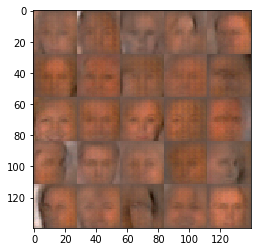

Epoch 1/1... Steps 2710... Discriminator Loss: 1.4068... Generator Loss: 0.4933...
Epoch 1/1... Steps 2720... Discriminator Loss: 1.1706... Generator Loss: 2.0482...
Epoch 1/1... Steps 2730... Discriminator Loss: 0.9963... Generator Loss: 1.2280...
Epoch 1/1... Steps 2740... Discriminator Loss: 1.3500... Generator Loss: 0.5995...
Epoch 1/1... Steps 2750... Discriminator Loss: 1.1204... Generator Loss: 0.9168...
Epoch 1/1... Steps 2760... Discriminator Loss: 1.4644... Generator Loss: 0.4978...
Epoch 1/1... Steps 2770... Discriminator Loss: 1.0510... Generator Loss: 1.3616...
Epoch 1/1... Steps 2780... Discriminator Loss: 1.2010... Generator Loss: 0.7116...
Epoch 1/1... Steps 2790... Discriminator Loss: 0.8838... Generator Loss: 1.2233...
Epoch 1/1... Steps 2800... Discriminator Loss: 0.8905... Generator Loss: 1.1981...


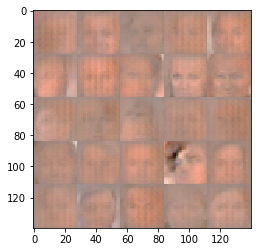

Epoch 1/1... Steps 2810... Discriminator Loss: 1.2409... Generator Loss: 0.6261...
Epoch 1/1... Steps 2820... Discriminator Loss: 1.0974... Generator Loss: 1.2768...
Epoch 1/1... Steps 2830... Discriminator Loss: 0.9152... Generator Loss: 1.3368...
Epoch 1/1... Steps 2840... Discriminator Loss: 0.8819... Generator Loss: 1.2033...
Epoch 1/1... Steps 2850... Discriminator Loss: 1.0378... Generator Loss: 0.8845...
Epoch 1/1... Steps 2860... Discriminator Loss: 1.0763... Generator Loss: 1.1157...
Epoch 1/1... Steps 2870... Discriminator Loss: 1.0000... Generator Loss: 1.5585...
Epoch 1/1... Steps 2880... Discriminator Loss: 0.7241... Generator Loss: 1.7513...
Epoch 1/1... Steps 2890... Discriminator Loss: 1.0415... Generator Loss: 1.0553...
Epoch 1/1... Steps 2900... Discriminator Loss: 0.9914... Generator Loss: 1.0003...


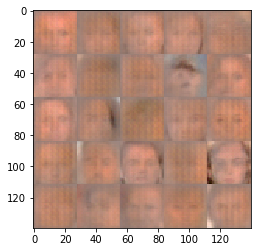

Epoch 1/1... Steps 2910... Discriminator Loss: 1.0149... Generator Loss: 1.2435...
Epoch 1/1... Steps 2920... Discriminator Loss: 0.9141... Generator Loss: 1.1551...
Epoch 1/1... Steps 2930... Discriminator Loss: 1.2707... Generator Loss: 0.7299...
Epoch 1/1... Steps 2940... Discriminator Loss: 1.0715... Generator Loss: 1.1465...
Epoch 1/1... Steps 2950... Discriminator Loss: 0.9994... Generator Loss: 1.1234...
Epoch 1/1... Steps 2960... Discriminator Loss: 1.0301... Generator Loss: 0.8835...
Epoch 1/1... Steps 2970... Discriminator Loss: 1.2075... Generator Loss: 1.4444...
Epoch 1/1... Steps 2980... Discriminator Loss: 1.0242... Generator Loss: 0.9276...
Epoch 1/1... Steps 2990... Discriminator Loss: 0.9287... Generator Loss: 0.9975...
Epoch 1/1... Steps 3000... Discriminator Loss: 1.0818... Generator Loss: 0.7896...


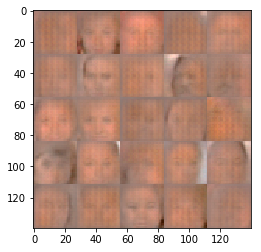

Epoch 1/1... Steps 3010... Discriminator Loss: 0.9910... Generator Loss: 0.9592...
Epoch 1/1... Steps 3020... Discriminator Loss: 0.7918... Generator Loss: 1.4216...
Epoch 1/1... Steps 3030... Discriminator Loss: 1.2208... Generator Loss: 1.2792...
Epoch 1/1... Steps 3040... Discriminator Loss: 1.0933... Generator Loss: 0.8874...
Epoch 1/1... Steps 3050... Discriminator Loss: 0.8727... Generator Loss: 1.1868...
Epoch 1/1... Steps 3060... Discriminator Loss: 0.9705... Generator Loss: 1.1783...
Epoch 1/1... Steps 3070... Discriminator Loss: 0.9376... Generator Loss: 1.0634...
Epoch 1/1... Steps 3080... Discriminator Loss: 1.0977... Generator Loss: 1.2753...
Epoch 1/1... Steps 3090... Discriminator Loss: 1.3977... Generator Loss: 0.4995...
Epoch 1/1... Steps 3100... Discriminator Loss: 1.0179... Generator Loss: 1.4287...


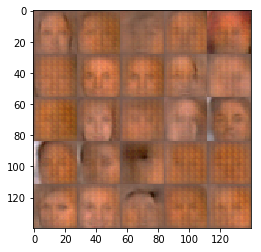

Epoch 1/1... Steps 3110... Discriminator Loss: 0.7592... Generator Loss: 1.6502...
Epoch 1/1... Steps 3120... Discriminator Loss: 0.7814... Generator Loss: 1.7003...
Epoch 1/1... Steps 3130... Discriminator Loss: 1.1445... Generator Loss: 1.0241...
Epoch 1/1... Steps 3140... Discriminator Loss: 0.9615... Generator Loss: 0.9534...
Epoch 1/1... Steps 3150... Discriminator Loss: 1.0230... Generator Loss: 1.3031...
Epoch 1/1... Steps 3160... Discriminator Loss: 0.9594... Generator Loss: 1.2543...


In [22]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.